# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system utilizes antibodes, and efforts to design antibodies that function more potently.

In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import optimize 
import pandas as pd

plt.style.use("ggplot")

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    # Check that there is a solution
    if diffFunAnon(0) * diffFunAnon(Rtot) > 0:
        raise RuntimeError("There is no solution with these parameters. Are your inputs correct?")

    # Vector of binomial coefficients
    Req = sp.optimize.brentq(diffFunAnon, 0, Rtot, disp=False)

    # Calculate vieq from equation 1
    vieq = L0*(1/Kd)*Req*(sp.special.binom(v, np.arange(1, v + 1))) * np.power(Kx*Req, np.arange(v))

    # Calculate L, according to equation 7
    Lbound = np.sum(vieq)

    # Calculate Rmulti from equation 5
    Rmulti = np.sum(np.multiply(vieq[1:], np.arange(2, v + 1, dtype=np.float)))

    # Calculate Rbound
    Rbnd = np.sum(np.multiply(vieq, np.arange(1, v + 1, dtype=np.float)))

    # Calculate numXlinks from equation 4
    nXlink = np.sum(np.multiply(vieq[1:], np.arange(1, v, dtype=np.float)))

    return (Lbound, Rbnd, Rmulti, nXlink)

data = np.loadtxt("./data/wk3-stone.csv", delimiter=",")

# Vector of the ligand concentrations, cell response (proportional to Rmulti), valencies
Xs, Ys, Vs = np.hsplit(data, 3)
Xs, Ys, Vs = np.squeeze(Xs), np.squeeze(Ys), np.squeeze(Vs)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

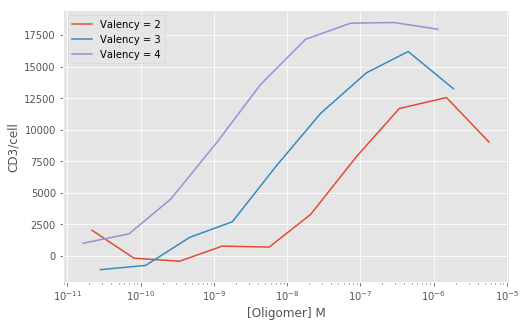

In [2]:
# Plot data from Figure 3B
plt.figure(1, figsize=(8,5))
plt.semilogx(Xs[0:10],Ys[0:10], label='Valency = 2')
plt.semilogx(Xs[10:19],Ys[10:19], label='Valency = 3')
plt.semilogx(Xs[19:28],Ys[19:28], label='Valency = 4')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3/cell' )
plt.legend()
plt.show()

From this plot, we see that the cell response increases as valency increases. Here, the Kd and Kx values are held constant for all three included valencies. 

#### (2) First, to fit our model to data, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

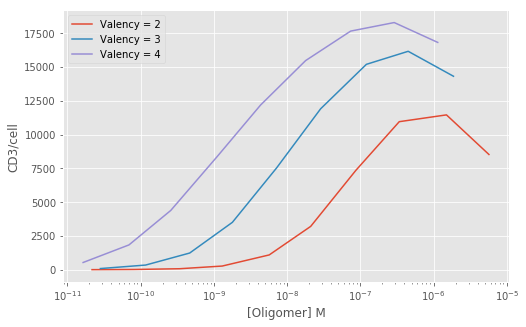

In [3]:
# Assign fit parameters shown in Table 1
Kd = (1.70 * 10**(-6))
Kx = (3.15 * 10**(-4))
Rtot = 24000
scale = 1

# Define function for scaling model predictions
def scaleMod(Rtot, Kd, v, Kx, L0, scale): 
    x = StoneMod(Rtot, Kd, v, Kx, L0)
    Rmulti = x[2]
    cell_response = Rmulti*scale
    return (cell_response)

# Run function for scaling parameters
scaledYs = np.zeros(28)
for i in range (0,28):
    scaledYs[i] = scaleMod(24000, Kd, Vs[i], Kx, Xs[i], scale)

plt.figure(2, figsize=(8,5))
plt.semilogx(Xs[0:10],scaledYs[0:10], label='Valency = 2')
plt.semilogx(Xs[10:19],scaledYs[10:19], label='Valency = 3')
plt.semilogx(Xs[19:28],scaledYs[19:28], label='Valency = 4')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3/cell' )
plt.legend()
plt.show()

#### (2) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [4]:
# Rename least squares function 
leastsq = sp.optimize.least_squares

# Define function to determine residuals between model and data, square of output will be minimized
def residuals(params, Rtot, Xs, Ys, Vs):
    length = len(Ys)
    modelY = np.zeros(length)
    for i in range (0,length):
        modelY[i] = scaleMod(Rtot, params[0], Vs[i], params[1], Xs[i], params[2])
    return (Ys - modelY)

# Create array for parameters that can be tuned during least squares
params = np.array([Kd, Kx, scale])

# Determine least squares solution and print
LSqVals = leastsq(residuals, params, args=(Rtot, Xs, Ys, Vs))

# Assign variables to optimized Kd, Kx, and scale values
Kd_opt = LSqVals.x[0]
Kx_opt = LSqVals.x[1]
scale_opt = LSqVals.x[2]

# Print optimized parameters
print('Least Squares Solution:')
print('Kd =', Kd_opt)
print('Kx =', Kx_opt)
print('scale =', scale_opt)

Least Squares Solution:
Kd = 1.70268189677e-06
Kx = 0.000314727518152
scale = 1.02815192019


#### (3) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

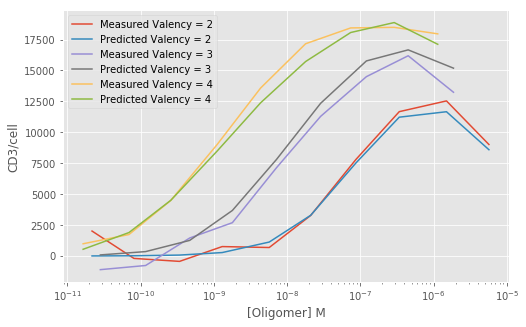

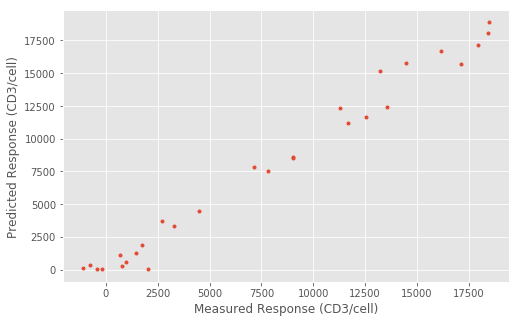

In [5]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

# Initialize zero vectors for new Xs, Ys, and Vs 
Xs_loo = np.zeros(27)
Ys_loo = np.zeros(27)
Vs_loo = np.zeros(27)

# Initialize zero vectors needed for splitting data into sets
bothYs = np.zeros((28,2))
testSet = np.zeros(3)

# Split Xs into training and test sets
for train, test in loo.split(Xs):
    
    # Create new vectors containing only training data
    for i in range (0,len(train)):
        Xs_loo[i] = Xs[train[i]]
        Ys_loo[i] = Ys[train[i]]
        Vs_loo[i] = Vs[train[i]]
        
    # Create vector containing Xs, Ys, Vs for test set
    testSet[0] = Xs[test]
    testSet[1] = Ys[test]
    testSet[2] = Vs[test]

    # Determine least squares solution and print
    LSqVals = leastsq(residuals, params, args=(Rtot, Xs_loo, Ys_loo, Vs_loo))
    
    # Input measured Y values
    bothYs[test,0] = testSet[1]
    
    # Predict scaled Y values for test set 
    bothYs[test,1] = scaleMod(24000, LSqVals.x[0] , testSet[2], LSqVals.x[1], testSet[0], LSqVals.x[2])

# Plot graph of measured and predicted cell responses
plt.figure(3, figsize=(8,5))
plt.semilogx(Xs[0:10],bothYs[0:10,0],label='Measured Valency = 2')
plt.semilogx(Xs[0:10],bothYs[0:10,1],label='Predicted Valency = 2')
plt.semilogx(Xs[10:19],bothYs[10:19,0],label='Measured Valency = 3')
plt.semilogx(Xs[10:19],bothYs[10:19,1],label='Predicted Valency = 3')
plt.semilogx(Xs[19:28],bothYs[19:128,0],label='Measured Valency = 4')
plt.semilogx(Xs[19:28],bothYs[19:128,1],label='Predicted Valency = 4')
plt.xlabel('[Oligomer] M')
plt.ylabel('CD3/cell' )
plt.legend()
plt.show()

# Plot graph of measured vs. predicted data
plt.figure(4, figsize=(8,5))
plt.plot(bothYs[:,0], bothYs[:,1], '.')
plt.xlabel('Measured Response (CD3/cell)')
plt.ylabel('Predicted Response (CD3/cell)')
plt.show()

This model does seem to accurately predict the data. In the first graph, we can see the similarities between the measured and predicted data for all three valencies. In the second graph, the measured data is plotted in relation to the predicted data, and the points appear in a linear fashion, which further indicates an accurate prediction.

#### (4) Using bootstrap estimation, plot the confidence interval of the model.

Standard deviation of Kd = 2.70037105509e-07 .
Standard deviation of Kx = 3.07669448427e-05 .
Standard deviation of scale factor = 0.0298009292983 .


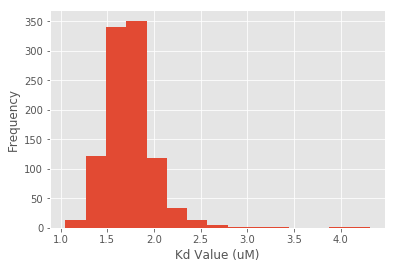

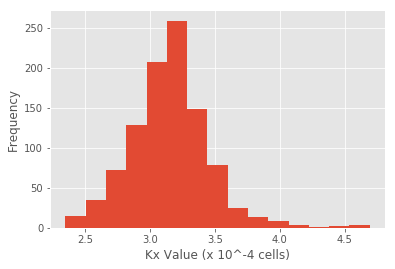

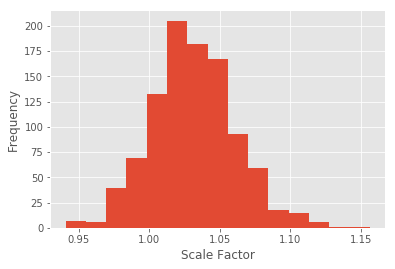

In [6]:
from sklearn.utils import resample

# Assign values to our parameters
Kd = (1.70 * 10**(-6))
Kx = (3.15 * 10**(-4))
Rtot = 24000
scale = 1

# Assign number of bootstraps we want to run
num_boots = 1000

Kds = np.zeros(num_boots)
Kxs = np.zeros(num_boots)
scales = np.zeros(num_boots)

for boots in range (num_boots):
    X_index = range(Xs.shape[0])
    resamp = resample(X_index)
    
    # Set up vectors of Xs, Ys, and Vs for current bootstrap
    Xcurr = Xs[resamp]
    Ycurr = Ys[resamp]
    Vcurr = Vs[resamp]
    
    # Run least squares on current bootstrap
    LSqVals = leastsq(residuals, params, args=(Rtot, Xcurr, Ycurr, Vcurr))
    
    # Save Kd, Kx, and scale from current bootstrap
    Kds[boots] = LSqVals.x[0]
    Kxs[boots] = LSqVals.x[1]
    scales[boots] = LSqVals.x[2]

# Print standard deviations
print('Standard deviation of Kd =', np.std(Kds),'.')
print('Standard deviation of Kx =', np.std(Kxs),'.')
print('Standard deviation of scale factor =', np.std(scales),'.')
    
# Plot histogram for Kd
plt.figure(5)
plt.hist(Kds*(10**6), 15)
plt.ylabel('Frequency')
plt.xlabel('Kd Value (uM)')
plt.show()

# Plot histogram for Kx
plt.figure(6)
plt.hist(Kxs*(10**4), 15)
plt.ylabel('Frequency')
plt.xlabel('Kx Value (x 10^-4 cells)')
plt.show()

# Plot histogram for scale
plt.figure(7)
plt.hist(scales, 15)
plt.ylabel('Frequency')
plt.xlabel('Scale Factor')
plt.show()

#### (5) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error.

Which parameter influences the fit the most? Which one the least?

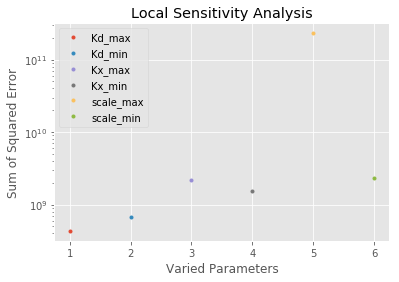

In [7]:
# Import sum from numpy
from numpy import sum

# Vary parameters up and down by 10-fold 
Kd_max = Kd_opt*10
Kd_min = Kd_opt/10
Kx_max = Kx_opt*10
Kx_min = Kx_opt/10
scale_max = scale_opt*10
scale_min = scale_opt/10

# Initialize vector for varied sum of squared errors
variedRes = np.zeros(6)

# Input varied paramters and save sum of their squares
variedRes[0] = sum(residuals([Kd_max, Kx_opt, scale_opt], Rtot, Xs, Ys, Vs)**2)
variedRes[1] = sum(residuals([Kd_min, Kx_opt, scale_opt], Rtot, Xs, Ys, Vs)**2)
variedRes[2] = sum(residuals([Kd_opt, Kx_max, scale_opt], Rtot, Xs, Ys, Vs)**2)
variedRes[3] = sum(residuals([Kd_opt, Kx_min, scale_opt], Rtot, Xs, Ys, Vs)**2)
variedRes[4] = sum(residuals([Kd_opt, Kx_opt, scale_max], Rtot, Xs, Ys, Vs)**2)
variedRes[5] = sum(residuals([Kd_opt, Kx_opt, scale_min], Rtot, Xs, Ys, Vs)**2)

# Initialize vector so we can plot sum of squares against each other
xaxis = np.linspace(1,6,num=6)
# Create vector containing residual labels
resLabels = ['Kd_max','Kd_min','Kx_max','Kx_min','scale_max','scale_min']

# Plot sum of square of residuals for each varied parameter
plt.figure(8)
for i in range (1,7):
    a = i-1
    plt.semilogy(xaxis[a],variedRes[a],'.',label=resLabels[a])
plt.ylabel('Sum of Squared Error')
plt.xlabel('Varied Parameters')
plt.title('Local Sensitivity Analysis')
plt.legend()
plt.show()

The local sensitivity analysis indicates that among the three parameters, scale influences the fit most and Kd influences the fit least. 

#### (6) While easier to perform, a local sensitivity analysis ignores co-dependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

I would anticipate that predictions for parameter values will be more specified with a global analysis than with a local analysis. In global analyis, using the least squares function allows us to optimize the other two parameters to minimize the error caused by the third parameter being very large or very small. Since these two parameters can be varied during global analysis, they will allow for a better and more specified model. 

#### (7) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when Kd increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver to hold your parameter of interest within a small range.

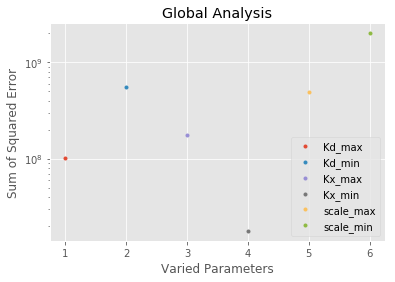

In [8]:
# Rename infinite function
inf = np.inf
eps = np.finfo(np.double).eps

# Create array for parameters that can be tuned during least squares
params0 = [Kd_max, Kx_opt, scale_opt]
params1 = [Kd_min, Kx_opt, scale_opt]
params2 = [Kd_opt, Kx_max, scale_opt]
params3 = [Kd_opt, Kx_min, scale_opt]
params4 = [Kd_opt, Kx_opt, scale_max]
params5 = [Kd_opt, Kx_opt, scale_min]

# Determine least squares solution and print
LSqVals0 = leastsq(residuals, params0, bounds=([Kd_max*.99,0,0], [Kd_max*1.01,inf,inf]), args=(Rtot, Xs, Ys, Vs))
LSqVals1 = leastsq(residuals, params1, bounds=([Kd_min*.99,0,0], [Kd_min*1.01,inf,inf]), args=(Rtot, Xs, Ys, Vs))
LSqVals2 = leastsq(residuals, params2, bounds=([0,Kx_max*.99,0], [inf,Kx_max*1.01,inf]), args=(Rtot, Xs, Ys, Vs))
LSqVals3 = leastsq(residuals, params3, bounds=([0,Kx_min*.99,0], [inf,Kx_max*1.01,inf]), args=(Rtot, Xs, Ys, Vs))
LSqVals4 = leastsq(residuals, params4, bounds=([0,0,scale_max*.99], [inf,inf,scale_max*1.01]), args=(Rtot, Xs, Ys, Vs))
LSqVals5 = leastsq(residuals, params5, bounds=([0,0,scale_min*.99], [inf,inf,scale_min*1.01]), args=(Rtot, Xs, Ys, Vs))

# Initialize vector for varied sum of squared errors
variedRes = np.zeros(6)

# Input varied paramters and save sum of their squares
variedRes[0] = sum(residuals(LSqVals0.x, Rtot, Xs, Ys, Vs)**2)
variedRes[1] = sum(residuals(LSqVals1.x, Rtot, Xs, Ys, Vs)**2)
variedRes[2] = sum(residuals(LSqVals2.x, Rtot, Xs, Ys, Vs)**2)
variedRes[3] = sum(residuals(LSqVals3.x, Rtot, Xs, Ys, Vs)**2)
variedRes[4] = sum(residuals(LSqVals4.x, Rtot, Xs, Ys, Vs)**2)
variedRes[5] = sum(residuals(LSqVals5.x, Rtot, Xs, Ys, Vs)**2)

# Initialize vector so we can plot sum of squares against each other
xaxis = np.linspace(1,6,num=6)

# Plot sum of square of residuals for each varied parameter
plt.figure(9)
for i in range (1,7):
    a = i-1
    plt.semilogy(xaxis[a],variedRes[a],'.',label=resLabels[a])
plt.ylabel('Sum of Squared Error')
plt.xlabel('Varied Parameters')
plt.title('Global Analysis')
plt.legend()
plt.show()

My prediction was true. Using least squares enables us to find more optimized parameters, which results in less error than the local analysis. This is indicated in our graphs from questions (5) and (7). The plotted sums of squared errors for each altered parameter during local analysis had an order of magnitude within the range 10^9 to 10^11. However, plotted sums of squared errors for each changed parameter during global analysis had an order of magnitude within the range 10^8 to 10^9 and were thus smaller than the local analysis errors.

#### (8) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters. Are these more or less exactly specified than Rmulti? What can you say about which quantities will be most exactly predicted?

Standard deviation of Lbounds = 0.263471083514 .
Adjusted standard deviation of Lbound =  0.0907903963393 .
Standard deviation of Rbnds = 0.454579025743 .
Adjusted standard deviation of Rbnds =  0.0875478612565 .
Standard deviation of Rmultis = 0.387422756144 .
Adjusted standard deviation of Rmultis =  0.0845761654006 .
Standard deviation of nXlinks = 0.193711378072 .
Adjusted standard deviation of nXlinks =  0.0845761654006 .


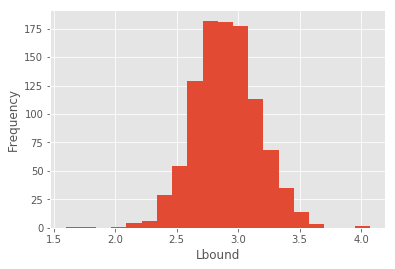

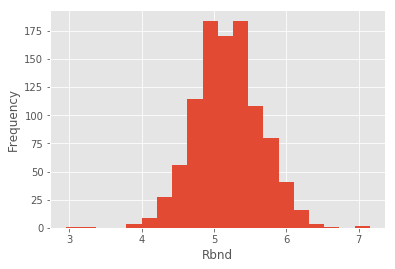

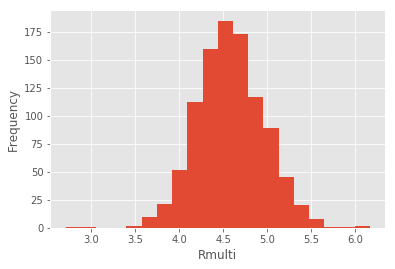

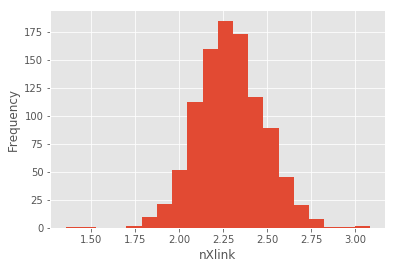

In [9]:
# Assign number of bootstraps we want to run
Lbounds = np.zeros(num_boots)
Rbnds = np.zeros(num_boots)
Rmultis = np.zeros(num_boots)
nXlinks = np.zeros(num_boots)

for i in range (num_boots):
    Lbounds[i] = StoneMod(Rtot,Kds[i],Vs[0],Kxs[i],Xs[0])[0]
    Rbnds[i] = StoneMod(Rtot,Kds[i],Vs[0],Kxs[i],Xs[0])[1]
    Rmultis[i] = StoneMod(Rtot,Kds[i],Vs[0],Kxs[i],Xs[0])[2]
    nXlinks[i] = StoneMod(Rtot,Kds[i],Vs[0],Kxs[i],Xs[0])[3]

# Print standard of Lbounds
print('Standard deviation of Lbounds =', np.std(Lbounds),'.')
print('Adjusted standard deviation of Lbound = ', np.std(Lbounds)/np.mean(Lbounds),'.')  
# Print standard of Rbnds
print('Standard deviation of Rbnds =', np.std(Rbnds),'.')
print('Adjusted standard deviation of Rbnds = ', np.std(Rbnds)/np.mean(Rbnds),'.')  
# Print standard of Rmultis
print('Standard deviation of Rmultis =', np.std(Rmultis),'.')
print('Adjusted standard deviation of Rmultis = ', np.std(Rmultis)/np.mean(Rmultis),'.') 
# Print standard of nXlinks
print('Standard deviation of nXlinks =', np.std(nXlinks),'.')
print('Adjusted standard deviation of nXlinks = ', np.std(nXlinks)/np.mean(nXlinks),'.')  

    
# Plot confidence and print standard deviation of Lbounds
plt.figure(10)
plt.hist(Lbounds, 20)
plt.ylabel('Frequency')
plt.xlabel('Lbound')
plt.show()

# Plot confidence and print standard deviation of Rbnds
plt.figure(11)
plt.hist(Rbnds, 20)
plt.ylabel('Frequency')
plt.xlabel('Rbnd')
plt.show()
  
# Plot confidence and print standard deviation of Rmultis
plt.figure(12)
plt.hist(Rmultis, 20)
plt.ylabel('Frequency')
plt.xlabel('Rmulti')
plt.show()

# Plot confidence and print standard deviation of nXlinks
plt.figure(13)
plt.hist(nXlinks, 20)
plt.ylabel('Frequency')
plt.xlabel('nXlink')
plt.show()

When we consider the original standard deviation values, we see that the standard deviation for Rbnds is greater than that of Rmulti. On the other hand, the standard deviations of Lbound and nXlink are smaller than that of Rmulti. When we consider the adjusted standard deviations, values for variables Rmulti and nXlink will be identical, as they have the same distribution. Additonally, the values for Lbound and Rbnd have adjusted standard deviations slightly higher than Rmulti, but they should not be extremely different. 

#### (9) Other quantities such as the number of bound receptors may be possible to measure as well. Describe how you would go about fitting this data along with the multimerized receptor measurements. In general, which do you think is better for exactly fitting the model: more measurements of the same type or more measurements of different types?

To answer this question, it is helpful to consider the bias-variance tradeoff. Including more measurements of different types, such as the number of bound receptors, introduces more variables into our model and makes it more complex. Making a model more complex will result in a smaller test error until we reach certain point of too many variables, at which the high complexity results in a variance that is too high. 

Since it is challenging to determine the complexity of the current model without much background, we do not yet know if we have reached our limit of beneficial variables. In order to improve the model, we could continue to include additional variables until we observe this increase in test error. Additionally, we  know that the best solution to minimizing prediction error is an infinitely large training set. Thus, if we were to choose between an infinite number of measurements or an infinite number of variables, we should select having more measurements of the same type to exactly fit the model. However, if we were choosing between twice as many measurements of the same type or twice as many measurements of different types, more measurements of different types may provide a superior fit. 

In order to fit these different quantities at the same time, we could incorporate them into our least squares optimization such that the parameters are set to minimize the error for both Lbound and Rmulti.